In [1]:
import sys,os
os.chdir('../../')
sys.path.append('./src/data')
sys.path.append('./src/events')
sys.path.append('./src/probability')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from DC.importer import *
from DC.processer import *
from DC.main import get_all_events,get_events
from functions import perform_chisq, dc_params_nsi, dc_params
from DC.event_processing import list_of_params_nsi, return_precomputed_nsi, get_deltachi
from scipy.stats import chi2
import pickle
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)
Ebins_2018_midpoints = Ebins_2018[0:-1] +np.diff(Ebins_2018)/2

In [2]:
ndim = 3
pid = 1
livetime = 2.45*365*24*3600 #Effective livetime table1 DC2019
precomputed_events = True
dc_params_nsi['dm_41'] = 0.93
dc_params['dm_41'] = 0.93
emm_range = np.linspace(0,0,1)
s24_range = np.linspace(0,0,1)
emt_range = np.linspace(-1e-2,1e-2,10)
param_list = list_of_params_nsi(dc_params_nsi,s24_range, emm_range,emt_range)

#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed_nsi(N=N,ndim=ndim, dict=p,check=False)



param_list = return_precomputed_nsi(pid,ndim,params=param_list)
emm_range = np.sort(np.unique(np.array([p['e_mm'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
emt_range = np.sort(np.unique(np.array([p['e_mt'] for p in param_list])))

print(emm_range)
print(s24_range)
print(emt_range)

#print(param_list[1])

[0.]
[0.]
[-0.01       -0.00777778 -0.00555556 -0.00333333 -0.00111111  0.00111111  0.00333333  0.00555556  0.00777778  0.01      ]


In [5]:
if not precomputed_events:
    print('Computing events')
    from multiprocessing import Pool
    data_H1 = [(p, pid,True) for p in param_list]
    data_H0 = [(Ebin,zbin,param_list[0],pid,False,False) for Ebin in range(8) for zbin in range(8)]
    p = Pool()
    H1_events_list = p.starmap(get_all_events, data_H1)
    H0_events = p.starmap(get_events, data_H0)
    p.close()
    H0_events = np.array(H0_events).reshape(8,8)
    pickle.dump(H1_events_list,open(f'./pre_computed/H1_DC_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','wb'))
    pickle.dump(H0_events,open(f'./pre_computed/H0_DC_{pid}.p','wb'))

H1_events_list = pickle.load(open(f'./pre_computed/H1_DC_{pid}_{len(emm_range)}x{len(emt_range)}_tau_nsi.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_DC_{pid}.p','rb'))

no_osc = get_all_events(params=param_list[0], pid=pid, nsi=True, no_osc=True)

Computing events


In [5]:
H0_events = get_all_events(params=param_list[0], pid=pid, nsi=False)

In [ ]:
no_osc_paper = no_osc2018_DC(pid)[1].values
track_factors = no_osc_paper / np.sum(no_osc,axis=1)

events = get_hist(events2018_DC().query('pid==1'), 'count_events')
background = get_hist(events2018_DC().query('pid==1'), 'count_background')

In [ ]:
best_fit_contamination = 0.055/(np.sum(background)/np.sum(events)) #table 1 DC2017

In [ ]:
track_paper = np.array([1273.0929915101788,
1324.139298304307,
1728.8833542945758,
2056.4569922784135,
2522.294295857107,
2480.0909490796657,
2132.423429507234,
1604.6895361059978])

In [ ]:
plt.scatter(Ebins_2018_midpoints, no_osc_paper - best_fit_contamination*np.sum(background,axis=1))
plt.scatter(Ebins_2018_midpoints, np.sum(no_osc,axis=1)*livetime*0.9)
plt.xscale('log')
plt.title('Comparing my noosc to DC')

In [ ]:
data = np.sum(events,axis=1)
no_norm = np.sum(H0_events*livetime +best_fit_contamination*background,axis=1)
norm = np.sum(H0_events*track_factors + best_fit_contamination*background,axis=1)
normalized_H1 = [H1*track_factors for H1 in H1_events_list]
H0_paper = pd.read_csv('./src/data/files/DC/2018/track_H0.csv', header=None)[1].values
H0_factors = H0_paper / np.sum(H0_events*livetime,axis=1)
#normalized_H1 = [H1*H0_factors for H1 in H1_events_list]

In [ ]:
plt.scatter(Ebins_2018_midpoints, H0_paper)
plt.scatter(Ebins_2018_midpoints, np.sum(H0_per_interaction,axis=0))
#plt.scatter(Ebins_2018_midpoints, np.sum(H0_events*livetime + best_fit_contamination*background,axis=1))
plt.fill_between(Ebins_2018_midpoints, np.sum(H1_events_list[0]*livetime + best_fit_contamination*background,axis=1), np.sum(H1_events_list[9]*livetime + best_fit_contamination*background,axis=1))
plt.xscale('log')
plt.title(r'Comparing my $3\nu$ to their $3\nu$')

In [63]:
df = MC2018_DC()
df.query('reco_energy> 30 and abs(pdg) == 14 and reco_coszen>0').describe()

,pdg,pid,reco_coszen,reco_energy,true_coszen,true_energy,type,weight
count,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,30460.000000,3.046000e+04
mean,6.035719,0.504728,0.423391,41.503011,0.281878,40.839801,2.478989,2.124984e-06
std,12.632313,0.499986,0.273291,5.952351,0.396286,38.692058,1.059378,3.349118e-05
min,-14.000000,0.000000,0.125000,36.900000,-0.999498,1.673077,0.000000,1.747577e-11
25%,-14.000000,0.000000,0.125000,36.900000,0.031303,24.563287,3.000000,4.518785e-08
50%,14.000000,1.000000,0.375000,36.900000,0.286129,33.326366,3.000000,1.127829e-07
75%,14.000000,1.000000,0.625000,49.200000,0.583987,44.978184,3.000000,2.731338e-07
max,14.000000,1.000000,0.875000,49.200000,0.999978,939.992004,3.000000,2.902235e-03


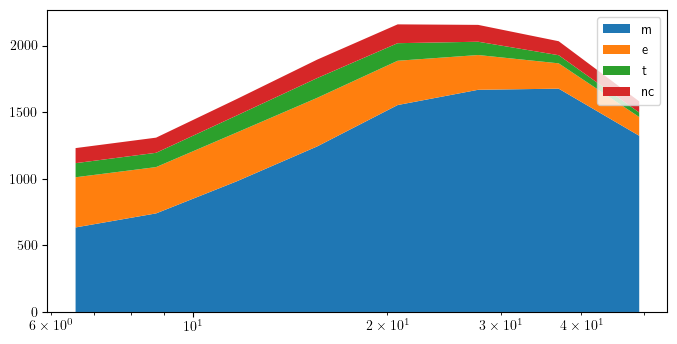

In [6]:
H0_per_interaction = np.sum(np.array(H0_events),axis=(0,3))*livetime
H0_per_interaction[[0,1],:] = H0_per_interaction[[1,0],:]
labels=['m','e','t','nc']
plt.stackplot(Ebins_2018_midpoints, H0_per_interaction, labels=labels)
plt.xscale('log')
plt.legend()

In [5]:
from numerical import wrapper 
z_range = np.linspace(0.01,0.1,100)
prob = np.array([wrapper(['m', [50],z, False, param_list[0], 3, False])[1] for i,z in enumerate(z_range)])

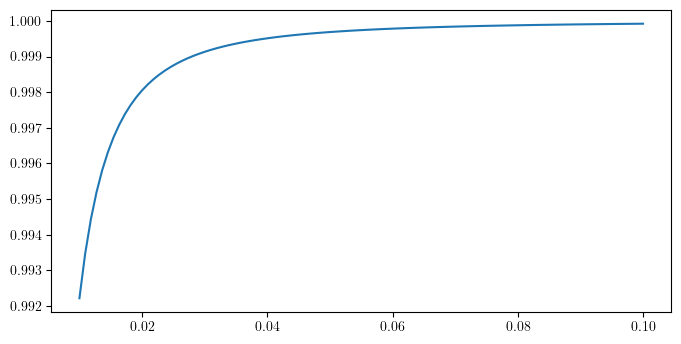

In [6]:
plt.plot(z_range, prob)

In [10]:
sigma_a = 0.25
sigma_b = 0.04
f = 1
deltachi,  best_fit_index, _ = get_deltachi([H1*livetime for H1 in H1_events_list],pid,emt_range,emm_range,0,[sigma_a,sigma_b],f,x0=[1,best_fit_contamination])
#s24_cl90, s24_cl99, emm_cl90, emm_cl99 = get_contour(deltachi.T, emt_range,emm_range,2)
#best_fit_coords = (param_list[best_index]['e_mt'], param_list[best_index]['e_mm'])

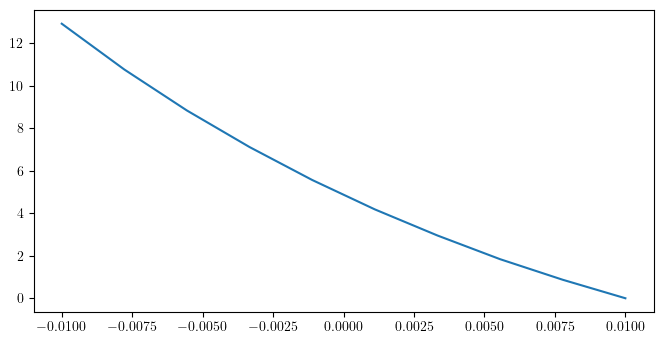

In [11]:
plt.plot(emt_range, deltachi)